# Policy
* 이 노트북 파일은 중간 과제를 재현Reproduce하는 증거로 활용.
    * 따라서, 이 노트북에 기재된 코드를 실행했을 때, Kaggle에 제출한 결과와 일치해야함
    * 무작위성 등으로 인하여 결과가 매번 달라지는 경우에는 Random Seed 등을 설정해서 항상 같은 결과가 나오도록 할 것(예. scikit-learn의 **random_state** 등)
* 다음과 같은 정책을 어길 시 0점 처리되니 유의할 것
    * 노트북에 기재된 코드를 전체 실행했을 때 오류 등으로 실행이 되지 않는 경우
    * 노트북에 명시되지 않은 별도의 코드 및 라이브러리를 사용하는 경우
        * 과제 수행에 필요한 외부 라이브러리 설치 명령은 이 노트북 내에 명시할 것(Installing Libraries 참조)
        * 별도의 Python 파일은 사용하지 말 것. 필요하다면 이 노트북 내에서 구현.
    * 중간 과제에서 제공한 데이터 이외의 별도의 데이터를 사용하는 경우
    * 노트북 파일 내에서 훈련된 모델이 아닌 다른 모델을 사용하는 경우
    * Kaggle 제출 결과와 노트북 파일 실행으로 나온 결과가 크게 다를 경우

# Installing Libraries

아래에 중간 과제를 수행하는 데 필요한 라이브러리 들을 설치하는 명령어를 넣을 것
예를 들어,
```shell
%conda install sklearn
```
또는
```shell
%pip install -U sklearn
```
버전이 중요하다면, 버전도 명확하게 명시할 것
```shell
%conda install sklearn==1.4.2
```
또는
```shell
%pip install sklearn==1.4.2
```

In [ ]:
# 설치하는 라이브러리 명시
!pip install -q scikit-learn==1.4.1.post1 numpy pandas altair kaggle==1.6.6 graphviz
!pip install -q xgboost lightgbm catboost statsmodels plotly imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
import os
from os import path
import json


import glob
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime

# misc
import warnings

# Data Load
아래에 중간 과제에 활용할 데이터를 불러오는 부분을 넣을 것

## Kaggle에서 데이터 다운로드

In [ ]:
USERNAME = "liebenholz" # username
USERKEY = "" # key

In [ ]:
json.dump({'username': USERNAME, 'key': USERKEY}, open('kaggle.json', mode='w'))

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c 2024-knu-ml-midterm
!unzip 2024-knu-ml-midterm.zip

 88% 17.0M/19.2M [00:00<00:00, 176MB/s]
100% 19.2M/19.2M [00:00<00:00, 179MB/s]
Archive:  2024-knu-ml-midterm.zip
  inflating: label.csv               
  inflating: sample_submission.csv   
  inflating: test.e4.acc-x.csv       
  inflating: test.e4.acc-y.csv       
  inflating: test.e4.acc-z.csv       
  inflating: test.e4.bvp.csv         
  inflating: test.e4.eda.csv         
  inflating: test.e4.hr.csv          
  inflating: test.e4.ibi.csv         
  inflating: test.e4.temp.csv        
  inflating: test.mindwave.alpha-high.csv  
  inflating: test.mindwave.alpha-low.csv  
  inflating: test.mindwave.beta-high.csv  
  inflating: test.mindwave.beta-low.csv  
  inflating: test.mindwave.delta.csv  
  inflating: test.mindwave.gamma-low.csv  
  inflating: test.mindwave.gamma-mid.csv  
  inflating: test.mindwave.theta.csv  
  inflating: train.e4.acc-x.csv      
  inflating: train.e4.acc-y.csv      
  inflating: train.e4.acc-z.csv      
  inflating: train.e4.bvp.csv        
  inflating: train

### Sensor Data Files
센서 데이터 파일은 각 센서값 별로 별도의 CSV 파일로 저장되어 있으며, 다음과 같은 파일명 형식을 따른다.

- train.{센서 종류}.{센서값 종류}.csv: 훈련 데이터
- test.{센서 종류}.{센서값 종류}.csv: 테스트 데이터


센서 종류는 다음과 같다.

- e4: Empatica E4 웨어러블 센서
- mindwave: NeuroSky Mindwave 뇌전도(EEG) 측정 헤드셋


센서값 종류는 다음과 같다.
- acc-x: 가속도계 X축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- acc-y: 가속도계 Y축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- acc-z: 가속도계 Z축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- bvp: 광혈류측정계(Photoplethysmography; PPG)를 통해 수집된 혈류파(Blood Volume Pulse); 단위는 nano watt
- eda: 피부전도도(Electrodermal Activity); 단위는 micro siemens
- hr: 심박수(Heart rate); 단위는 beat per minute
- ibi: 심박 간격(Inter-beat Interval); 단위는 milliseconds
- temp: 피부 온도; 단위는 섭씨(Celsius degree)
- delta: 뇌파 - 델타파(delta wave; 0.5 - 2.75Hz 대역)의 상대적 강도
- theta: 뇌파 - 세타파(theta wave; 3.5 - 6.75Hz 대역)의 상대적 강도
- alpha-low: 뇌파 - 저대역 알파파(low-alpha wave; 7.5 - 9.25Hz 대역)의 상대적 강도
- alpha-high: 뇌파- 고대역 알파파(high-alpha wave; 10 - 11.75Hz 대역)의 상대적 강도
- beta-low: 뇌파 - 저대역 베타파(low-beta wave; 13 - 16.75Hz 대역)의 상대적 강도
- beta-high: 뇌파 - 고대역 베타파(high-beta wave; 18 - 29.75Hz 대역)의 상대적 강도
- gamma-low: 뇌파 - 저대역 베타파(low-gamma wave; 31 - 39.75Hz 대역)의 상대적 강도
- gamma-mid: 뇌파 - 중대역 감마파(mid-gamma wave; 41 - 49.75Hz 대역)의 상대적 강도

※ 뇌파의 상대적 강도는 별도의 단위가 없으며, 다른 대역과 비교했을때의 상대적 신호 강도를 의미한다. 정규화 또는 일반화 된 값이라고 여기면 된다.


각 센서 데이터 파일은 3개의 필드로 구성되어 있다

- timestamp: 해당 센서값이 수집된 millisecond 단위의 시점; 서로 다른 피험자의 센서 데이터가 서로 겹치지 않도록 시간을 조정하였다.
- value: 수집된 센서 값
- pid: 피험자 ID로, A부터 Y까지 총 25명이다. 이 중 12명은 훈련 데이터, 13명은 테스트 데이터로 활용된다.
  - 훈련(train) 데이터 : W, T, U, F, J, Q, O, R, B, G, C, H
  - 테스트(test) 데이터

### Label Files
훈련 데이터에 대한 레이블 정보는 label.csv에 기록되어 있으며, 다음과 같이 2개의 필드로 구성되어 있다.

- id: 감정 레이블이 부여된 millisecond 단위의 시점
서로 다른 피험자의 레이블이 서로 겹치지 않도록 값을 조정하였다.
- label: 레이블 값으로 0, 1, 2, 3의 값이 존재한다.
  - 0 - 조용하고 부정적인 감정(예. 우울함, 피곤함, 지루함 등)
  - 1 - 조용하고 긍정적인 감정(예. 침착함, 편안함 등)
  - 2 - 활달하고 부정적인 감정(예. 화남, 긴장함 등)
  - 3 - 활달하고 긍정적인 감정(예. 행복함, 신남 등)
### Submission
테스트 데이터에 대한 예측 id 및 제출 예시는 sample_submission.csv에 기록되어 있으며, label.csv와 동일한 필드 및 의미를 가진다.

## 다운로드한 데이터 불러오기

In [ ]:
# pd.read_csv(...)
LABEL = pd.read_csv('./label.csv', index_col='id')
SAMPLE = pd.read_csv('./sample_submission.csv', index_col='id')

TRAIN_E4X = pd.read_csv('./train.e4.acc-x.csv')
TRAIN_E4Y = pd.read_csv('./train.e4.acc-y.csv')
TRAIN_E4Z = pd.read_csv('./train.e4.acc-z.csv')
TRAIN_BVP = pd.read_csv('./train.e4.bvp.csv')
TRAIN_EDA = pd.read_csv('./train.e4.eda.csv')
TRAIN_HR = pd.read_csv('./train.e4.hr.csv')
TRAIN_IBI = pd.read_csv('./train.e4.ibi.csv')
TRAIN_TEMP = pd.read_csv('./train.e4.temp.csv')
TRAIN_ALPHA_H = pd.read_csv('./train.mindwave.alpha-high.csv')
TRAIN_ALPHA_L = pd.read_csv('./train.mindwave.alpha-low.csv')
TRAIN_BETA_H = pd.read_csv('./train.mindwave.beta-high.csv')
TRAIN_BETA_L = pd.read_csv('./train.mindwave.beta-low.csv')
TRAIN_DELTA = pd.read_csv('./train.mindwave.delta.csv')
TRAIN_GAMMA_L = pd.read_csv('./train.mindwave.gamma-low.csv')
TRAIN_GAMMA_M = pd.read_csv('./train.mindwave.gamma-mid.csv')
TRAIN_THETA = pd.read_csv('./train.mindwave.theta.csv')

TEST_E4X = pd.read_csv('./test.e4.acc-x.csv')
TEST_E4Y = pd.read_csv('./test.e4.acc-y.csv')
TEST_E4Z = pd.read_csv('./test.e4.acc-z.csv')
TEST_BVP = pd.read_csv('./test.e4.bvp.csv')
TEST_EDA = pd.read_csv('./test.e4.eda.csv')
TEST_HR = pd.read_csv('./test.e4.hr.csv')
TEST_IBI = pd.read_csv('./test.e4.ibi.csv')
TEST_TEMP = pd.read_csv('./test.e4.temp.csv')
TEST_ALPHA_H = pd.read_csv('./test.mindwave.alpha-high.csv')
TEST_ALPHA_L = pd.read_csv('./test.mindwave.alpha-low.csv')
TEST_BETA_H = pd.read_csv('./test.mindwave.beta-high.csv')
TEST_BETA_L = pd.read_csv('./test.mindwave.beta-low.csv')
TEST_DELTA = pd.read_csv('./test.mindwave.delta.csv')
TEST_GAMMA_L = pd.read_csv('./test.mindwave.gamma-low.csv')
TEST_GAMMA_M = pd.read_csv('./test.mindwave.gamma-mid.csv')
TEST_THETA = pd.read_csv('./test.mindwave.theta.csv')

# Data Preprocessing, Feature Engineering, and Model Building

이곳부터는 데이터 전처리, 특성값 공학, 모델 훈련 등의 코드를 자유롭게 넣을 것

## I. Dataset Exploration

다운로드 받은 데이터를 Pandas Dataframe으로 불러옴


In [ ]:
print(LABEL.shape)
LABEL.head()

(1440, 1)


,label
id,
2860000,1
2865000,1
2870000,1
2875000,1
2880000,1


### 1. E4 센서 측정값

In [ ]:
print(TRAIN_E4X.shape)
TRAIN_E4X.head()

(455092, 3)


,timestamp,value,pid
0,1922000,53.0,W
1,1922031,53.0,W
2,1922062,53.0,W
3,1922093,53.0,W
4,1922125,53.0,W


In [ ]:
print(TRAIN_E4Y.shape)
TRAIN_E4Y.head()

(455092, 3)


,timestamp,value,pid
0,1922000,-1.0,W
1,1922031,-1.0,W
2,1922062,-1.0,W
3,1922093,-1.0,W
4,1922125,-1.0,W


In [ ]:
print(TRAIN_E4Z.shape)
TRAIN_E4Z.head()

(455092, 3)


,timestamp,value,pid
0,1922000,32.0,W
1,1922031,33.0,W
2,1922062,33.0,W
3,1922093,32.0,W
4,1922125,32.0,W


In [ ]:
print(TRAIN_BVP.shape)
TRAIN_BVP.head()

(910178, 3)


,timestamp,value,pid
0,1922000,0.0,W
1,1922015,0.0,W
2,1922031,0.0,W
3,1922046,0.0,W
4,1922062,0.0,W


In [ ]:
print(TRAIN_EDA.shape)
TRAIN_EDA.head()

(56888, 3)


,timestamp,value,pid
0,1922000,0.000000,W
1,1922250,0.829071,W
2,1922500,1.176600,W
3,1922750,1.614910,W
4,1923000,2.092975,W


In [ ]:
print(TRAIN_HR.shape)
TRAIN_HR.head()

(14102, 3)


,timestamp,value,pid
0,1932000,72.0,W
1,1933000,62.0,W
2,1934000,65.0,W
3,1935000,69.5,W
4,1936000,75.2,W


In [ ]:
print(TRAIN_IBI.shape)
TRAIN_IBI.head()

(7371, 3)


,timestamp,value,pid
0,1946532,671.906,W
1,1947235,703.157,W
2,1947923,687.531,W
3,1948641,718.783,W
4,1949438,796.911,W


In [ ]:
print(TRAIN_TEMP.shape)
TRAIN_TEMP.head()

(56880, 3)


,timestamp,value,pid
0,1922000,30.57,W
1,1922250,30.57,W
2,1922500,30.57,W
3,1922750,30.57,W
4,1923000,30.57,W


### 2. Mindwave 센서 측정값

In [ ]:
print(TRAIN_ALPHA_H.shape)
TRAIN_ALPHA_H.head()

(12885, 3)


,timestamp,value,pid
0,2191889,2,W
1,2192990,0,W
2,2193882,12242,W
3,2194895,100,W
4,2195889,2716,W


In [ ]:
print(TRAIN_ALPHA_L.shape)
TRAIN_ALPHA_L.head()

(12885, 3)


,timestamp,value,pid
0,2191889,10,W
1,2192990,0,W
2,2193882,98803,W
3,2194895,227,W
4,2195889,24537,W


In [ ]:
print(TRAIN_BETA_H.shape)
TRAIN_BETA_H.head()

(12885, 3)


,timestamp,value,pid
0,2191889,1,W
1,2192990,0,W
2,2193882,5441,W
3,2194895,62,W
4,2195889,483,W


In [ ]:
print(TRAIN_BETA_L.shape)
TRAIN_BETA_L.head()

(12885, 3)


,timestamp,value,pid
0,2191889,5,W
1,2192990,0,W
2,2193882,37467,W
3,2194895,55,W
4,2195889,6811,W


In [ ]:
print(TRAIN_DELTA.shape)
TRAIN_DELTA.head()

(12885, 3)


,timestamp,value,pid
0,2191889,10,W
1,2192990,0,W
2,2193882,79467,W
3,2194895,42,W
4,2195889,8168,W


In [ ]:
print(TRAIN_GAMMA_L.shape)
TRAIN_GAMMA_L.head()

(12885, 3)


,timestamp,value,pid
0,2191889,1,W
1,2192990,0,W
2,2193882,5210,W
3,2194895,52,W
4,2195889,445,W


In [ ]:
print(TRAIN_GAMMA_M.shape)
TRAIN_GAMMA_M.head()

(12885, 3)


,timestamp,value,pid
0,2191889,116,W
1,2192990,0,W
2,2193882,614527,W
3,2194895,841,W
4,2195889,89011,W


In [ ]:
print(TRAIN_THETA.shape)
TRAIN_THETA.head()

(12885, 3)


,timestamp,value,pid
0,2191889,44,W
1,2192990,1,W
2,2193882,114488,W
3,2194895,1617,W
4,2195889,67630,W


## II. Data Preparation

다운로드 받은 데이터 테이블을 센서 종류에 따라 분류하고, 시간대 순으로 정렬하고 통합한다.

데이터에서 겹치는 시간대의 데이터가 존재하지 않는다. 피험자들의 데이터들이 모두 다른 시간대에 위치하고 있기 때문에 pid는 필요하지 않을 것으로 예측된다

### 1. Train 데이터 통합

In [ ]:
label = LABEL.reset_index()
label = label[['id', 'label']].rename(
    {'id': 'timestamp'}, axis=1
)
e4_accx = TRAIN_E4X[['timestamp', 'value']].rename(
    {'value': 'x'}, axis=1
)
e4_accy = TRAIN_E4Y[['timestamp', 'value']].rename(
    {'value': 'y'}, axis=1
)
e4_accz = TRAIN_E4Z[['timestamp', 'value']].rename(
    {'value': 'z'}, axis=1
)
e4_pid = TRAIN_E4X[['timestamp', 'value']].rename(
    {'value': 'pid'}, axis=1
)
e4_bvp = TRAIN_BVP[['timestamp', 'value']].rename(
    {'value': 'bvp'}, axis=1
)
e4_eda = TRAIN_EDA[['timestamp', 'value']].rename(
    {'value': 'eda'}, axis=1
)
e4_hr = TRAIN_HR[['timestamp', 'value']].rename(
    {'value': 'hr'}, axis=1
)
e4_ibi = TRAIN_IBI[['timestamp', 'value']].rename(
    {'value': 'ibi'}, axis=1
)
e4_temp = TRAIN_TEMP[['timestamp', 'value']].rename(
    {'value': 'temp'}, axis=1
)
e4_pid = TRAIN_BVP[['timestamp', 'pid']]

In [ ]:
mv_alphaH = TRAIN_ALPHA_H[['timestamp', 'value']].rename(
    {'value': 'alpha_high'}, axis=1
)
mv_alphaL = TRAIN_ALPHA_L[['timestamp', 'value']].rename(
    {'value': 'alpha_low'}, axis=1
)
mv_betaH = TRAIN_BETA_H[['timestamp', 'value']].rename(
    {'value': 'beta_high'}, axis=1
)
mv_betaL = TRAIN_BETA_L[['timestamp', 'value']].rename(
    {'value': 'beta_low'}, axis=1
)
mv_delta = TRAIN_DELTA[['timestamp', 'value']].rename(
    {'value': 'delta'}, axis=1
)
mv_gammaL = TRAIN_GAMMA_L[['timestamp', 'value']].rename(
    {'value': 'gamma_low'}, axis=1
)
mv_gammaM = TRAIN_GAMMA_M[['timestamp', 'value']].rename(
    {'value': 'gamma_mid'}, axis=1
)
mv_theta = TRAIN_THETA[['timestamp', 'value']].rename(
    {'value': 'theta'}, axis=1
)
mv_pid = TRAIN_ALPHA_H[['timestamp', 'pid']]

In [ ]:
train =  label.set_index('timestamp').join(
    e4_accx.set_index('timestamp'), how='outer', rsuffix='_2'
).join(
    e4_accy.set_index('timestamp'), how='outer', rsuffix='_3'
).join(
    e4_accz.set_index('timestamp'), how='outer', rsuffix='_4'
).join(
  e4_bvp.set_index('timestamp'), how='outer', rsuffix='_5'
).join(
    e4_eda.set_index('timestamp'), how='outer', rsuffix='_6'
).join(
    e4_hr.set_index('timestamp'), how='outer', rsuffix='_7'
).join(
    e4_ibi.set_index('timestamp'), how='outer', rsuffix='_8'
).join(
    e4_temp.set_index('timestamp'), how='outer', rsuffix='_9'
).join(
    mv_alphaH.set_index('timestamp'), how='outer', rsuffix='_10'
).join(
    mv_alphaL.set_index('timestamp'), how='outer', rsuffix='_11'
).join(
    mv_betaH.set_index('timestamp'), how='outer', rsuffix='_12'
).join(
    mv_betaL.set_index('timestamp'), how='outer', rsuffix='_13'
).join(
    mv_delta.set_index('timestamp'), how='outer', rsuffix='_14'
).join(
    mv_gammaL.set_index('timestamp'), how='outer', rsuffix='_15'
).join(
    mv_gammaM.set_index('timestamp'), how='outer', rsuffix='_16'
).join(
    mv_theta.set_index('timestamp'), how='outer', rsuffix='_17'
)

In [ ]:
train

,label,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta
timestamp,,,,,,,,,,,,,,,,,
1922000,NaN,53.0,-1.0,32.0,0.00,0.0,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922015,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922031,NaN,53.0,-1.0,33.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922046,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922062,NaN,53.0,-1.0,33.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43958937,NaN,53.0,15.0,19.0,18.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43958953,NaN,NaN,NaN,NaN,18.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43958968,NaN,65.0,11.0,15.0,19.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
unsampled = train.drop(['label'], axis=1)
interpolated = unsampled.interpolate(method='linear')
interpolated

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta
timestamp,,,,,,,,,,,,,,,,
1922000,53.0,-1.0,32.0,0.00,0.000000,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922015,53.0,-1.0,32.5,0.00,0.051817,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922031,53.0,-1.0,33.0,0.00,0.103634,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922046,53.0,-1.0,33.0,0.00,0.155451,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922062,53.0,-1.0,33.0,0.00,0.207268,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43958937,53.0,15.0,19.0,18.34,0.216545,115.43,718.783,30.19,2684.0,703.0,878.0,1913.0,2053.0,2786.0,54956.0,24463.0
43958953,59.0,13.0,17.0,18.27,0.216545,115.43,718.783,30.19,2684.0,703.0,878.0,1913.0,2053.0,2786.0,54956.0,24463.0
43958968,65.0,11.0,15.0,19.79,0.216545,115.43,718.783,30.19,2684.0,703.0,878.0,1913.0,2053.0,2786.0,54956.0,24463.0


In [ ]:
LERP = interpolated.reset_index()
LERP = LERP.set_index('timestamp').join(
    label.set_index('timestamp'), how='outer', rsuffix='_18'
)
LERP

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta,label
timestamp,,,,,,,,,,,,,,,,,
1922000,53.0,-1.0,32.0,0.00,0.000000,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922015,53.0,-1.0,32.5,0.00,0.051817,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922031,53.0,-1.0,33.0,0.00,0.103634,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922046,53.0,-1.0,33.0,0.00,0.155451,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922062,53.0,-1.0,33.0,0.00,0.207268,NaN,NaN,30.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43958937,53.0,15.0,19.0,18.34,0.216545,115.43,718.783,30.19,2684.0,703.0,878.0,1913.0,2053.0,2786.0,54956.0,24463.0,NaN
43958953,59.0,13.0,17.0,18.27,0.216545,115.43,718.783,30.19,2684.0,703.0,878.0,1913.0,2053.0,2786.0,54956.0,24463.0,NaN
43958968,65.0,11.0,15.0,19.79,0.216545,115.43,718.783,30.19,2684.0,703.0,878.0,1913.0,2053.0,2786.0,54956.0,24463.0,NaN


In [ ]:
TRAIN = LERP.dropna()
for c in TRAIN.columns:
    print(f'{c}: {len(TRAIN[c].loc[TRAIN[c].isnull()])}')

x: 0
y: 0
z: 0
bvp: 0
eda: 0
hr: 0
ibi: 0
temp: 0
alpha_high: 0
alpha_low: 0
beta_high: 0
beta_low: 0
delta: 0
gamma_low: 0
gamma_mid: 0
theta: 0
label: 0


In [ ]:
TRAIN

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta,label
timestamp,,,,,,,,,,,,,,,,,
2860000,30.0,-2.0,54.0,-6.20,0.303961,83.13,748.146216,29.13,13246.065574,5751.409836,16819.852459,11185.311475,10065.508197,12758.950820,132572.573770,40048.622951,1.0
2865000,35.0,-3.0,52.0,-31.69,0.301398,83.02,742.022515,29.11,4090.707692,7789.184615,3678.892308,5521.600000,3608.461538,5678.830769,243448.169231,41785.600000,1.0
2870000,38.0,-2.0,50.0,3.28,0.296272,83.02,735.898815,29.07,21664.200000,31878.200000,20912.200000,18462.600000,11231.000000,21656.600000,620220.600000,206335.200000,1.0
2875000,63.0,0.0,9.0,-342.00,0.289865,83.60,729.775114,29.05,15613.265625,15891.375000,8150.562500,26915.453125,16857.437500,12733.156250,142952.312500,25144.453125,1.0
2880000,61.0,-1.0,-15.0,19.23,0.321900,84.23,723.651413,29.17,14758.636364,5251.545455,4205.090909,20469.545455,12773.818182,4552.090909,46982.363636,41663.818182,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43939000,31.0,29.0,-23.0,12.76,0.202450,115.87,718.783000,30.23,5816.363636,7738.818182,2941.363636,4032.545455,9880.863636,5282.318182,96026.681818,73556.363636,3.0
43944000,45.0,39.0,53.0,28.76,0.207576,116.22,718.783000,30.19,4541.575758,6150.606061,3714.787879,7244.681818,6328.121212,5715.439394,174180.545455,62386.242424,3.0
43949000,31.0,41.0,-3.0,-1.39,0.213982,116.33,718.783000,30.19,7610.587302,19578.158730,4529.047619,6198.603175,11526.666667,7804.904762,140548.476190,45623.650794,3.0


### 2. Test 데이터 통합

Train 데이터 테이블을 통합한 것과 같은 방법으로 Test 데이터 테이블 역시 통합한다.

In [ ]:
sample = SAMPLE.reset_index()
sample = sample[['id', 'label']].rename(
    {'id': 'timestamp'}, axis=1
)
e4_accx = TEST_E4X[['timestamp', 'value']].rename(
    {'value': 'x'}, axis=1
)
e4_accy = TEST_E4Y[['timestamp', 'value']].rename(
    {'value': 'y'}, axis=1
)
e4_accz = TEST_E4Z[['timestamp', 'value']].rename(
    {'value': 'z'}, axis=1
)
e4_pid = TEST_E4X[['timestamp', 'value']].rename(
    {'value': 'pid'}, axis=1
)
e4_bvp = TEST_BVP[['timestamp', 'value']].rename(
    {'value': 'bvp'}, axis=1
)
e4_eda = TEST_EDA[['timestamp', 'value']].rename(
    {'value': 'eda'}, axis=1
)
e4_hr = TEST_HR[['timestamp', 'value']].rename(
    {'value': 'hr'}, axis=1
)
e4_ibi = TEST_IBI[['timestamp', 'value']].rename(
    {'value': 'ibi'}, axis=1
)
e4_temp = TEST_TEMP[['timestamp', 'value']].rename(
    {'value': 'temp'}, axis=1
)
e4_pid = TEST_BVP[['timestamp', 'pid']]

In [ ]:
mv_alphaH = TEST_ALPHA_H[['timestamp', 'value']].rename(
    {'value': 'alpha_high'}, axis=1
)
mv_alphaL = TEST_ALPHA_L[['timestamp', 'value']].rename(
    {'value': 'alpha_low'}, axis=1
)
mv_betaH = TEST_BETA_H[['timestamp', 'value']].rename(
    {'value': 'beta_high'}, axis=1
)
mv_betaL = TEST_BETA_L[['timestamp', 'value']].rename(
    {'value': 'beta_low'}, axis=1
)
mv_delta = TEST_DELTA[['timestamp', 'value']].rename(
    {'value': 'delta'}, axis=1
)
mv_gammaL = TEST_GAMMA_L[['timestamp', 'value']].rename(
    {'value': 'gamma_low'}, axis=1
)
mv_gammaM = TEST_GAMMA_M[['timestamp', 'value']].rename(
    {'value': 'gamma_mid'}, axis=1
)
mv_theta = TEST_THETA[['timestamp', 'value']].rename(
    {'value': 'theta'}, axis=1
)
mv_pid = TEST_ALPHA_H[['timestamp', 'pid']]

In [ ]:
test = label.set_index('timestamp').join(
    e4_accx.set_index('timestamp'), how='outer', rsuffix='_2'
).join(
    e4_accy.set_index('timestamp'), how='outer', rsuffix='_3'
).join(
    e4_accz.set_index('timestamp'), how='outer', rsuffix='_4'
).join(
  e4_bvp.set_index('timestamp'), how='outer', rsuffix='_5'
).join(
    e4_eda.set_index('timestamp'), how='outer', rsuffix='_6'
).join(
    e4_hr.set_index('timestamp'), how='outer', rsuffix='_7'
).join(
    e4_ibi.set_index('timestamp'), how='outer', rsuffix='_8'
).join(
    e4_temp.set_index('timestamp'), how='outer', rsuffix='_9'
).join(
    mv_alphaH.set_index('timestamp'), how='outer', rsuffix='_10'
).join(
    mv_alphaL.set_index('timestamp'), how='outer', rsuffix='_11'
).join(
    mv_betaH.set_index('timestamp'), how='outer', rsuffix='_12'
).join(
    mv_betaL.set_index('timestamp'), how='outer', rsuffix='_13'
).join(
    mv_delta.set_index('timestamp'), how='outer', rsuffix='_14'
).join(
    mv_gammaL.set_index('timestamp'), how='outer', rsuffix='_15'
).join(
    mv_gammaM.set_index('timestamp'), how='outer', rsuffix='_16'
).join(
    mv_theta.set_index('timestamp'), how='outer', rsuffix='_17'
)

In [ ]:
test

,label,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta
timestamp,,,,,,,,,,,,,,,,,
0,NaN,58.0,14.0,19.0,0.0,0.0,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,58.0,14.0,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,58.0,14.0,18.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43939000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43944000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43949000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
unsampled = test.drop(['label'], axis=1)
interpolated = unsampled.interpolate(method='linear')
interpolated

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta
timestamp,,,,,,,,,,,,,,,,
0,58.0,14.0,19.0,0.00,0.000000,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,58.0,14.0,19.0,0.00,0.051817,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,58.0,14.0,19.0,0.00,0.103634,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,58.0,14.0,18.5,0.00,0.155451,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,58.0,14.0,18.0,0.00,0.207268,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43939000,10.0,61.0,17.0,0.43,0.621333,78.93,687.531,29.35,24528.0,37695.0,22139.0,8636.0,15887.0,14946.0,746403.0,171135.0
43944000,10.0,61.0,17.0,0.43,0.621333,78.93,687.531,29.35,24528.0,37695.0,22139.0,8636.0,15887.0,14946.0,746403.0,171135.0
43949000,10.0,61.0,17.0,0.43,0.621333,78.93,687.531,29.35,24528.0,37695.0,22139.0,8636.0,15887.0,14946.0,746403.0,171135.0


In [ ]:
lerp = interpolated.reset_index()
lerp = lerp.set_index('timestamp').join(
    sample.set_index('timestamp'), how='outer', rsuffix='_18'
)
lerp

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta,label
timestamp,,,,,,,,,,,,,,,,,
0,58.0,14.0,19.0,0.00,0.000000,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,58.0,14.0,19.0,0.00,0.051817,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,58.0,14.0,19.0,0.00,0.103634,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,58.0,14.0,18.5,0.00,0.155451,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,58.0,14.0,18.0,0.00,0.207268,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43939000,10.0,61.0,17.0,0.43,0.621333,78.93,687.531,29.35,24528.0,37695.0,22139.0,8636.0,15887.0,14946.0,746403.0,171135.0,NaN
43944000,10.0,61.0,17.0,0.43,0.621333,78.93,687.531,29.35,24528.0,37695.0,22139.0,8636.0,15887.0,14946.0,746403.0,171135.0,NaN
43949000,10.0,61.0,17.0,0.43,0.621333,78.93,687.531,29.35,24528.0,37695.0,22139.0,8636.0,15887.0,14946.0,746403.0,171135.0,NaN


In [ ]:
test2 = lerp.dropna()
for c in test2.columns:
    print(f'{c}: {len(test2[c].loc[test2[c].isnull()])}')

x: 0
y: 0
z: 0
bvp: 0
eda: 0
hr: 0
ibi: 0
temp: 0
alpha_high: 0
alpha_low: 0
beta_high: 0
beta_low: 0
delta: 0
gamma_low: 0
gamma_mid: 0
theta: 0
label: 0


In [ ]:
test2

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta,label
timestamp,,,,,,,,,,,,,,,,,
727000,1.0,-9.0,62.0,-0.91,10.143337,103.63,531.274000,29.07,52495.793651,120098.476190,8388.238095,73626.317460,29248.126984,23238.746032,4.494447e+05,475508.349206,-1.0
732000,1.0,-9.0,62.0,-7.12,10.118990,103.87,531.274000,29.05,87027.531250,119778.875000,9455.968750,116201.156250,105778.968750,19171.312500,1.279234e+06,389983.187500,-1.0
737000,0.0,-9.0,62.0,-0.62,9.951125,103.83,531.274000,29.07,28126.651515,23274.196970,2153.681818,19093.621212,22102.666667,5675.303030,4.861317e+05,141530.030303,-1.0
742000,0.0,-9.0,62.0,-124.01,9.925497,103.13,531.274000,29.07,108165.939394,45102.303030,10051.363636,102878.151515,193117.121212,22661.151515,1.659590e+06,499873.060606,-1.0
747000,2.0,-9.0,61.0,-1.63,10.122834,103.07,531.274000,29.07,62032.800000,294807.200000,10191.200000,185272.400000,155923.600000,29378.400000,7.115518e+05,618314.600000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42256000,-20.0,1.0,60.0,5.94,0.673829,78.38,818.675786,29.21,19863.909091,5389.272727,18637.787879,38993.969697,21458.060606,13785.333333,1.251674e+06,530046.212121,-1.0
42261000,-20.0,0.0,60.0,13.60,0.669988,78.73,720.112851,29.21,22404.641791,45987.582090,5085.597015,26008.507463,40674.731343,5942.820896,1.733273e+06,115934.701493,-1.0
42266000,8.0,62.0,16.0,10.46,0.666147,78.93,807.342686,29.19,11733.562500,26504.750000,1990.187500,12156.468750,9960.687500,3165.062500,1.831724e+05,42292.281250,-1.0


In [ ]:
unsampled2 = test2.reset_index()
unsampled2 = unsampled2.set_index('timestamp').join(
    sample.set_index('timestamp'), how='outer', rsuffix='_18'
)
unsampled2

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta,label,label_18
timestamp,,,,,,,,,,,,,,,,,,
727000,1.0,-9.0,62.0,-0.91,10.143337,103.63,531.274000,29.07,52495.793651,120098.476190,8388.238095,73626.317460,29248.126984,23238.746032,4.494447e+05,475508.349206,-1.0,-1
732000,1.0,-9.0,62.0,-7.12,10.118990,103.87,531.274000,29.05,87027.531250,119778.875000,9455.968750,116201.156250,105778.968750,19171.312500,1.279234e+06,389983.187500,-1.0,-1
737000,0.0,-9.0,62.0,-0.62,9.951125,103.83,531.274000,29.07,28126.651515,23274.196970,2153.681818,19093.621212,22102.666667,5675.303030,4.861317e+05,141530.030303,-1.0,-1
742000,0.0,-9.0,62.0,-124.01,9.925497,103.13,531.274000,29.07,108165.939394,45102.303030,10051.363636,102878.151515,193117.121212,22661.151515,1.659590e+06,499873.060606,-1.0,-1
747000,2.0,-9.0,61.0,-1.63,10.122834,103.07,531.274000,29.07,62032.800000,294807.200000,10191.200000,185272.400000,155923.600000,29378.400000,7.115518e+05,618314.600000,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42261000,-20.0,0.0,60.0,13.60,0.669988,78.73,720.112851,29.21,22404.641791,45987.582090,5085.597015,26008.507463,40674.731343,5942.820896,1.733273e+06,115934.701493,-1.0,-1
42266000,8.0,62.0,16.0,10.46,0.666147,78.93,807.342686,29.19,11733.562500,26504.750000,1990.187500,12156.468750,9960.687500,3165.062500,1.831724e+05,42292.281250,-1.0,-1
42271000,9.0,61.0,17.0,-15.30,0.650782,78.80,755.346840,29.23,6882.439394,41638.303030,2088.590909,7087.181818,5843.212121,2537.287879,4.264287e+05,37173.803030,-1.0,-1


In [ ]:
interpolated2 = unsampled2.interpolate(method='linear')
interpolated2

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta,label,label_18
timestamp,,,,,,,,,,,,,,,,,,
727000,1.0,-9.0,62.0,-0.91,10.143337,103.63,531.274000,29.07,52495.793651,120098.476190,8388.238095,73626.317460,29248.126984,23238.746032,4.494447e+05,475508.349206,-1.0,-1
732000,1.0,-9.0,62.0,-7.12,10.118990,103.87,531.274000,29.05,87027.531250,119778.875000,9455.968750,116201.156250,105778.968750,19171.312500,1.279234e+06,389983.187500,-1.0,-1
737000,0.0,-9.0,62.0,-0.62,9.951125,103.83,531.274000,29.07,28126.651515,23274.196970,2153.681818,19093.621212,22102.666667,5675.303030,4.861317e+05,141530.030303,-1.0,-1
742000,0.0,-9.0,62.0,-124.01,9.925497,103.13,531.274000,29.07,108165.939394,45102.303030,10051.363636,102878.151515,193117.121212,22661.151515,1.659590e+06,499873.060606,-1.0,-1
747000,2.0,-9.0,61.0,-1.63,10.122834,103.07,531.274000,29.07,62032.800000,294807.200000,10191.200000,185272.400000,155923.600000,29378.400000,7.115518e+05,618314.600000,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42261000,-20.0,0.0,60.0,13.60,0.669988,78.73,720.112851,29.21,22404.641791,45987.582090,5085.597015,26008.507463,40674.731343,5942.820896,1.733273e+06,115934.701493,-1.0,-1
42266000,8.0,62.0,16.0,10.46,0.666147,78.93,807.342686,29.19,11733.562500,26504.750000,1990.187500,12156.468750,9960.687500,3165.062500,1.831724e+05,42292.281250,-1.0,-1
42271000,9.0,61.0,17.0,-15.30,0.650782,78.80,755.346840,29.23,6882.439394,41638.303030,2088.590909,7087.181818,5843.212121,2537.287879,4.264287e+05,37173.803030,-1.0,-1


In [ ]:
lerp2 = interpolated2.drop(['label'], axis=1)
lerp3 = lerp2.drop(['label_18'], axis=1)

TEST = lerp3.dropna()
for c in TEST.columns:
    print(f'{c}: {len(TEST[c].loc[TEST[c].isnull()])}')

TEST

x: 0
y: 0
z: 0
bvp: 0
eda: 0
hr: 0
ibi: 0
temp: 0
alpha_high: 0
alpha_low: 0
beta_high: 0
beta_low: 0
delta: 0
gamma_low: 0
gamma_mid: 0
theta: 0


,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta
timestamp,,,,,,,,,,,,,,,,
727000,1.0,-9.0,62.0,-0.91,10.143337,103.63,531.274000,29.07,52495.793651,120098.476190,8388.238095,73626.317460,29248.126984,23238.746032,4.494447e+05,475508.349206
732000,1.0,-9.0,62.0,-7.12,10.118990,103.87,531.274000,29.05,87027.531250,119778.875000,9455.968750,116201.156250,105778.968750,19171.312500,1.279234e+06,389983.187500
737000,0.0,-9.0,62.0,-0.62,9.951125,103.83,531.274000,29.07,28126.651515,23274.196970,2153.681818,19093.621212,22102.666667,5675.303030,4.861317e+05,141530.030303
742000,0.0,-9.0,62.0,-124.01,9.925497,103.13,531.274000,29.07,108165.939394,45102.303030,10051.363636,102878.151515,193117.121212,22661.151515,1.659590e+06,499873.060606
747000,2.0,-9.0,61.0,-1.63,10.122834,103.07,531.274000,29.07,62032.800000,294807.200000,10191.200000,185272.400000,155923.600000,29378.400000,7.115518e+05,618314.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42261000,-20.0,0.0,60.0,13.60,0.669988,78.73,720.112851,29.21,22404.641791,45987.582090,5085.597015,26008.507463,40674.731343,5942.820896,1.733273e+06,115934.701493
42266000,8.0,62.0,16.0,10.46,0.666147,78.93,807.342686,29.19,11733.562500,26504.750000,1990.187500,12156.468750,9960.687500,3165.062500,1.831724e+05,42292.281250
42271000,9.0,61.0,17.0,-15.30,0.650782,78.80,755.346840,29.23,6882.439394,41638.303030,2088.590909,7087.181818,5843.212121,2537.287879,4.264287e+05,37173.803030


## III. Data Preprocessing

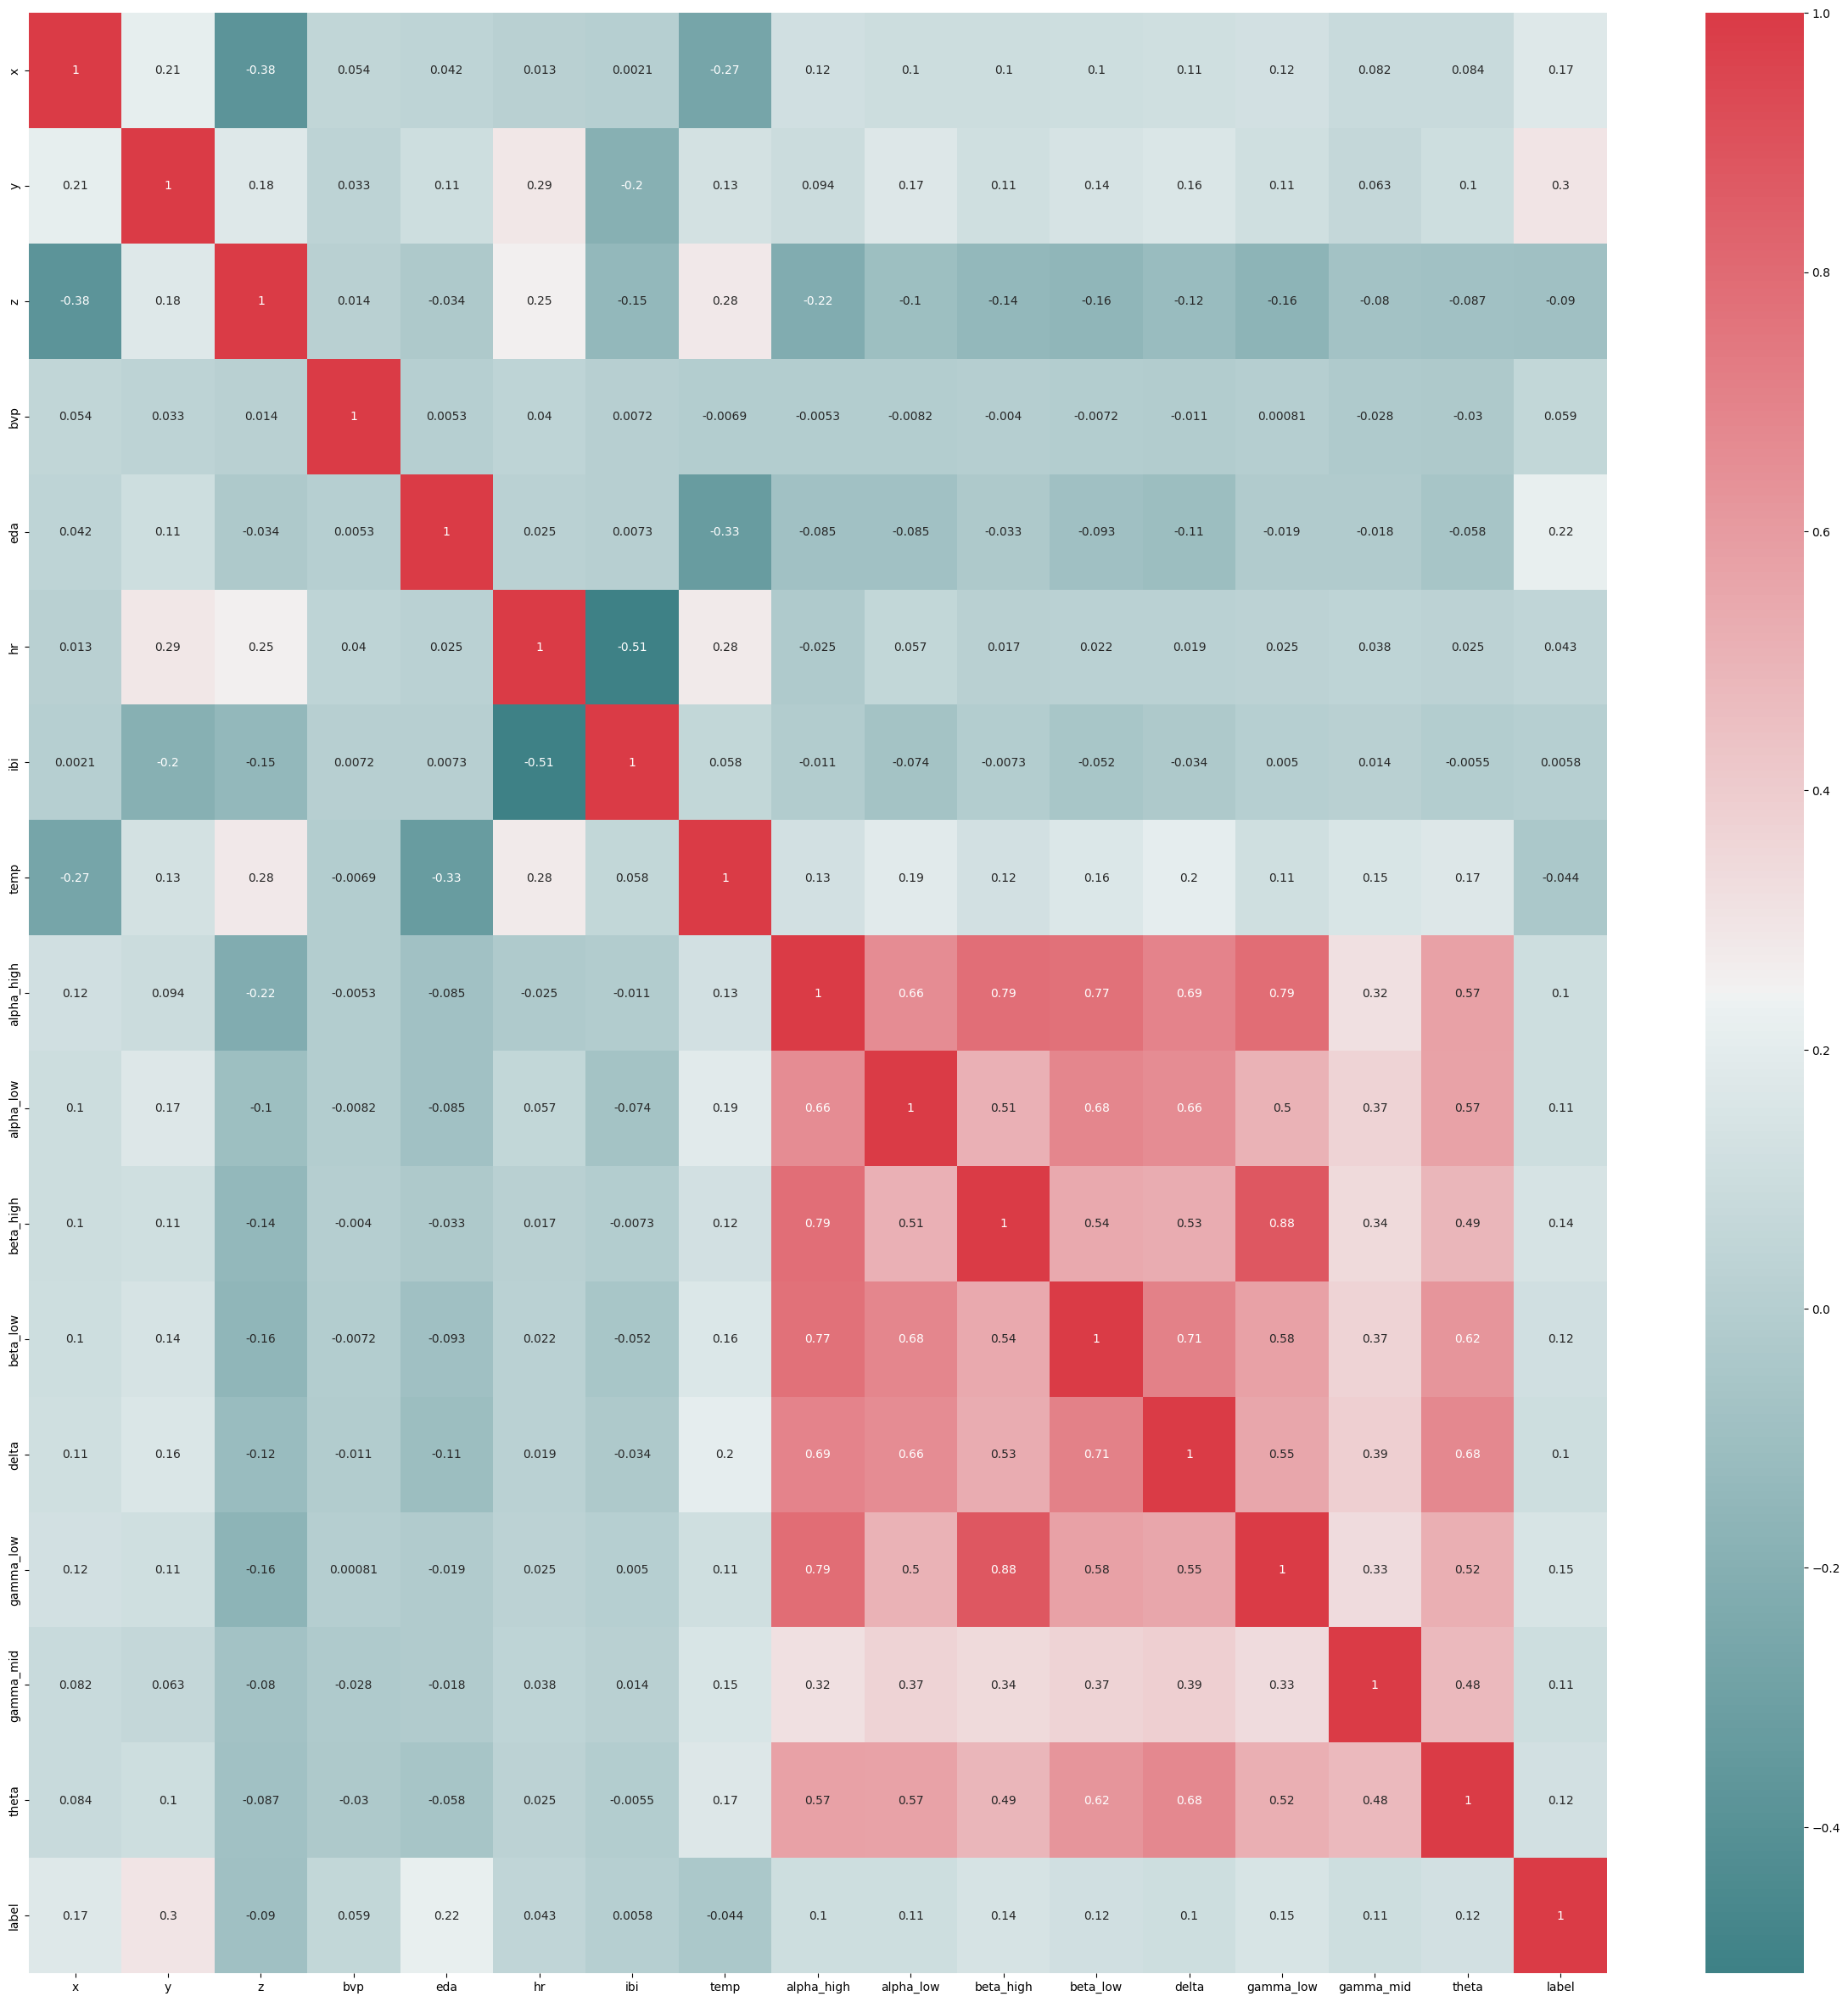

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,20))
corr = TRAIN.corr()
sns.heatmap(corr,annot=True,cmap=sns.diverging_palette(200, 10, as_cmap=True))
plt.show()

In [ ]:
TRAIN_CORR = TRAIN.corr()['label']
TRAIN_ABS = TRAIN_CORR.abs().sort_values(ascending=True)
TRAIN_ABS = pd.DataFrame(TRAIN_ABS)
TRAIN_ABS

,label
ibi,0.005775
hr,0.043180
temp,0.043715
bvp,0.059473
z,0.090082
alpha_high,0.102167
delta,0.103599
gamma_mid,0.105340
alpha_low,0.107033
beta_low,0.115472


## IV. Feature Engineering

**Description**

25명의 피험자들이 사회적으로 민감한 주제에 대해 10분 동안 토론하는 동안, Empatica E4 웨어러블 센서를 통해 생리학적 반응을, NeuroSky Mindwave EEG 헤드셋을 뇌파를 수집한 데이터임.

토론 이후, 5명의 외부 평가자가 녹화된 토론 과정을 보면서 5초 단위로 각 피험자의 감정을 레이블함. 5명이 레이블한 감정은 합쳐서 하나의 감정으로 변환되었음.


**label**: 레이블 값으로 0, 1, 2, 3의 값이 존재한다.
- 0 - 조용하고 부정적인 감정(예. 우울함, 피곤함, 지루함 등)
- 1 - 조용하고 긍정적인 감정(예. 침착함, 편안함 등)
- 2 - 활달하고 부정적인 감정(예. 화남, 긴장함 등)
- 3 - 활달하고 긍정적인 감정(예. 행복함, 신남 등)

array([[<Axes: title={'center': 'label'}>]], dtype=object)

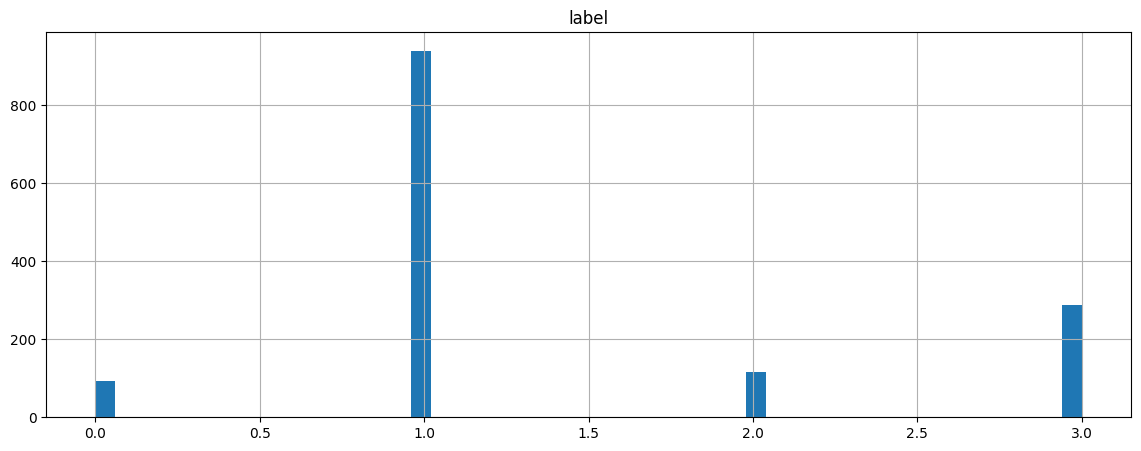

In [ ]:
LABEL.hist(bins = 50, figsize = (14, 5))

In [ ]:
LABEL["label"].value_counts(normalize=True)

label
1    0.652778
3    0.200694
2    0.081250
0    0.065278
Name: proportion, dtype: float64

특성값 공학을 통해서 (0,1), (2,3)으로 묶어서 라벨링해도 될 것 같다는 생각이 들었다. 조용한 감정과 활달한 감정을 위주로 확실히 분류하고, 0과 2와 같은 부정적인 감정을 보통 잘 드러나지 않기 때문에, 1과 3으로 다시 라벨링을 하면 적어도 이에 대한 정확도를 높일 수 있을 것 같다.

## V. Model Building

In [ ]:
df = TRAIN.copy()

In [ ]:
X, y = df.drop('label', axis=1), df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

### Linear Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(
    fit_intercept=False
).fit(
    X_train, y_train
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import accuracy_score


print('# Training performance')
print('- Logistic Regression: ', accuracy_score(y_train, model_lr.predict(X_train)))

print('# Validation performance')
print('- Logistic Regression: ', accuracy_score(y_test, model_lr.predict(X_test)))

# Training performance
- Logistic Regression:  0.5720486111111112
# Validation performance
- Logistic Regression:  0.5625


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=0)

model_dt = DecisionTreeClassifier(
    random_state=0
).fit(
    X_train,y_train
)

In [ ]:
from sklearn.metrics import accuracy_score

print('# Training performance')
print('- Decision Tree: ', accuracy_score(y_train, model_dt.predict(X_train)))

print('# Validation performance')
print('- Decision Tree: ', accuracy_score(y_test, model_dt.predict(X_test)))

# Training performance
- Decision Tree:  1.0
# Validation performance
- Decision Tree:  0.7708333333333334


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    max_features='sqrt',
    max_samples=0.5,  # 전체 훈련 샘플 중 50%만 Bootstrap한다
    random_state=42
).fit(
    X_train, y_train
)

In [ ]:
from sklearn.metrics import accuracy_score

print('# Training performance')
print('- Random Forest: ', accuracy_score(y_train, model_rf.predict(X_train)))

print('# Validation performance')
print('- Random Forest: ', accuracy_score(y_test, model_rf.predict(X_test)))

# Training performance
- Random Forest:  0.7690972222222222
# Validation performance
- Random Forest:  0.71875


### Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model_ab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42), # 깊이 1의 Decision Tree
    n_estimators=100, # 최대 100개의 Stump를 만들 것이다. 중간에 Loss가 0가 된다면, 더 이상 Stump를 생성하지 않고 훈련이 종료된다.
    learning_rate=1.0, # 각 Stump가 미치는 영향
    random_state=42
).fit(
    X_train, y_train
)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score

print('# Training performance')
print('- Ada Boost: ', accuracy_score(y_train, model_ab.predict(X_train)))

print('# Validation performance')
print('- Ada Boost: ', accuracy_score(y_test, model_ab.predict(X_test)))

# Training performance
- Ada Boost:  0.5677083333333334
# Validation performance
- Ada Boost:  0.4826388888888889


### XG Boost

In [ ]:
from xgboost import XGBClassifier


model_xgb = XGBClassifier(
    n_estimators=100, # 최대 100개의 Decision Tree를 만들 것이다. 하지만, 중간에 Loss가 0가 된다면, 더 이상 Decision Tree를 생성하지 않고 훈련이 종료된다.
    learning_rate=0.1, # 각 Decision Tree가 결과에 미치는 영향을 나타낸다(Shrinkage). 과대적합을 막기 위해서 낮은 값으로 설정해보자
    subsample=0.8, # 각 Decision Tree 훈련에 사용할 샘플의 개수를 나타낸다. 80%만 활용해보자.
    max_depth=3, # Decision Tree의 깊이를 나타낸다. 많이 깊어지지 않도록 해보자.
    random_state=42
).fit(
    X_train, y_train
)

In [ ]:
from sklearn.metrics import accuracy_score

print('# Training performance')
print('- XGBoost: ', accuracy_score(y_train, model_xgb.predict(X_train)))

print('# Validation performance')
print('- XGBoost: ', accuracy_score(y_test, model_xgb.predict(X_test)))

# Training performance
- XGBoost:  0.9461805555555556
# Validation performance
- XGBoost:  0.7916666666666666


# Final Model Specification
아래에는 위 전 과정을 거쳐서 최종적으로 선정된 모델을 정의하고 훈련할 것

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(...)

In [ ]:
from sklearn.ensemble import VotingClassifier

ens1 = VotingClassifier(estimators=[('model_rf', model_rf), ('model_lr', model_lr), ('model_ab',model_ab), ('model_xgb',model_xgb)], voting='soft')
ens1.fit(X_train, y_train)

y_pred = ens1.predict(X_test)
print("Accuracy :",round(accuracy_score(y_test,y_pred)*100,2),"%")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy : 71.88 %


In [ ]:
ens2 = VotingClassifier(estimators=[('model_rf', model_rf), ('model_lr', model_lr), ('model_ab',model_ab), ('model_xgb',model_xgb)], voting='hard')
ens2.fit(X_train, y_train)

y_pred = ens2.predict(X_test)
print("Accuracy :",round(accuracy_score(y_test,y_pred)*100,2),"%")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy : 73.26 %


In [ ]:
TEST.head()

,x,y,z,bvp,eda,hr,ibi,temp,alpha_high,alpha_low,beta_high,beta_low,delta,gamma_low,gamma_mid,theta
timestamp,,,,,,,,,,,,,,,,
727000,1.0,-9.0,62.0,-0.91,10.143337,103.63,531.274,29.07,52495.793651,120098.47619,8388.238095,73626.317460,29248.126984,23238.746032,4.494447e+05,475508.349206
732000,1.0,-9.0,62.0,-7.12,10.118990,103.87,531.274,29.05,87027.531250,119778.87500,9455.968750,116201.156250,105778.968750,19171.312500,1.279234e+06,389983.187500
737000,0.0,-9.0,62.0,-0.62,9.951125,103.83,531.274,29.07,28126.651515,23274.19697,2153.681818,19093.621212,22102.666667,5675.303030,4.861317e+05,141530.030303
742000,0.0,-9.0,62.0,-124.01,9.925497,103.13,531.274,29.07,108165.939394,45102.30303,10051.363636,102878.151515,193117.121212,22661.151515,1.659590e+06,499873.060606
747000,2.0,-9.0,61.0,-1.63,10.122834,103.07,531.274,29.07,62032.800000,294807.20000,10191.200000,185272.400000,155923.600000,29378.400000,7.115518e+05,618314.600000


In [ ]:
import numpy as np
import pandas as pd

y_test_pred = ens1.predict(TEST)
y_test_pred

array([1., 1., 1., ..., 1., 1., 1.])

# Generate Submission
아래에는 Kaggle에 제출한 결과를 PC에 저장하는 코드를 넣을 것.
노트북 실행 후 아래의 코드를 통해 생성된 결과가 Kaggle에 제출된 결과와 일치해야 함.

In [ ]:
SUBMIT = pd.DataFrame({
    'id': SAMPLE.index,
    'label': y_test_pred
})
SUBMIT

,id,label
0,727000,1.0
1,732000,1.0
2,737000,1.0
3,742000,1.0
4,747000,1.0
...,...,...
1555,42261000,1.0
1556,42266000,1.0
1557,42271000,1.0
1558,42276000,1.0


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'label'}>]], dtype=object)

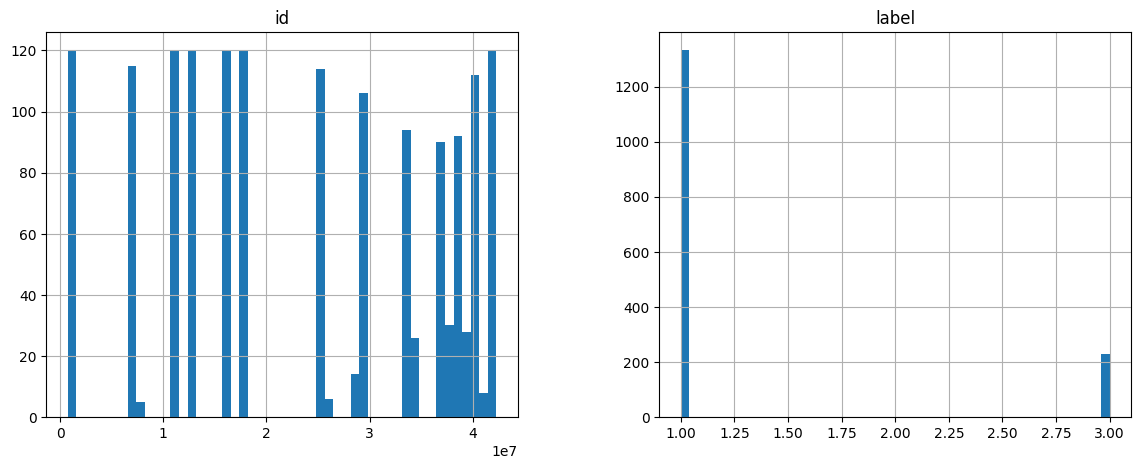

In [ ]:
SUBMIT.hist(bins = 50, figsize = (14, 5))

In [ ]:
SUBMIT["label"].value_counts(normalize=True)
# SUBMIT["label"].value_counts()

label
1.0    1331
3.0     228
2.0       1
Name: count, dtype: int64

In [ ]:
SUBMIT.to_csv('./submission.csv', index=False)

In [ ]:
!kaggle competitions submit --file submission.csv --message "Submission: Ensemble Learning 02" 2024-knu-ml-midterm

100% 19.5k/19.5k [00:00<00:00, 27.2kB/s]
Successfully submitted to Midterm Assignment